<a href="https://colab.research.google.com/github/ahmedemam576/-Landmark-Detection-Tracking-SLAM-/blob/main/Transformer_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer Interpretability Beyond Attention Visualization**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 386 (delta 3), reused 2 (delta 2), pack-reused 381 (from 2)
Receiving objects: 100% (386/386), 3.85 MiB | 22.27 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [11]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}

# dataset and vit model

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from datetime import datetime
import sys
from tqdm import tqdm
import numpy as np
import random
import wandb  # Import weights and biases
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
import sys
import os
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import random
# First add the parent directory to path if needed
import sys
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import tifffile as tiff
# --- Core Fixes Start Here ---

# Add the parent directory to the path once
# This makes 'Transformer-Explainability' a top-level module we can import from.
sys.path.append(os.path.abspath("Transformer-Explainability"))

# Now, import directly using the full module path from sys.path
try:
    # Use the correct module path based on your directory structure:
    from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
    from baselines.ViT.ViT_explanation_generator import LRP
    # Assuming modules/layers_ours.py is also inside Transformer-Explainability
    from modules.layers_ours import Linear

    print("Successfully imported ViT_LRP and LRP.")

except ImportError as e:
    print(f"Error importing modules: {e}")
    print(f"sys.path currently contains: {sys.path}")
    print("Please ensure that __init__.py files are present in all subdirectories (Transformer-Explainability/, baselines/, baselines/ViT/).")




# Set seed for reproducibility
def set_seed(seed=42):
    """Set seed for all random number generators for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Setting to False for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✅ Random seed set to {seed} for reproducibility")

# Set the seed right at the beginning
set_seed(42)

# Import your existing code
sys.path.append(os.path.abspath("Transformer-Explainability"))
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from modules.layers_ours import Linear  # Import Linear from layers_ours


# Create save directory
today = datetime.now().strftime("%Y%m%d")
save_dir = f"lrp_class_and_recon_model_weights_{today}"
os.makedirs(save_dir, exist_ok=True)

#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs_classification = 5

batch_size = 1
num_workers = 2
num_classes = 2
lr_classification = 2e-5

sample_frac = 0.5  # Training dataset fraction
# Log dataset info to wandb
import gc
gc.collect()

# 1. CLASSIFICATION MODEL TRAINING
print("\n=== TRAINING CLASSIFICATION MODEL ===\n")
torch.cuda.empty_cache()
# Initialize ViT model for classification
vit_classification = vit_LRP(pretrained=True).to(device)

# Modify the head for binary classification (2 outputs)
# Use Linear from layers_ours for LRP compatibility
vit_classification.head = Linear(vit_classification.head.in_features, num_classes).to(device)
def min_max_normalize(image_tensor):
    """
    Performs per-image, per-channel Min-Max normalization.
    Input: image_tensor (Tensor) of shape (C, H, W)
    Output: normalized_tensor (Tensor) with values in [0.0, 1.0]
    """
    # Ensure input is a float tensor (ToTensor() usually handles this)
    if image_tensor.dtype != torch.float32:
        image_tensor = image_tensor.to(torch.float32)

    # Calculate min and max for each channel
    # dims=[1, 2] calculates min/max across height and width for each channel C
    c_min = image_tensor.amin(dim=[1, 2], keepdim=True)
    c_max = image_tensor.amax(dim=[1, 2], keepdim=True)

    # Handle cases where max - min might be zero (e.g., solid color image)
    # Use torch.clamp for numerical stability if needed
    denominator = c_max - c_min
    denominator = torch.clamp(denominator, min=1e-6)

    normalized_tensor = (image_tensor - c_min) / denominator

    return normalized_tensor
# --- Define the new Dataset Class for Inference ---

class InferenceDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations (test.csv format).
            image_folder (string): Directory with all the images (output/images).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_folder, self.annotations.iloc[idx, 0])
        image = cv2.imread(img_name)

        if image is None:
            raise FileNotFoundError(f"Image not found at {img_name}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # >>> Get original dimensions here <<<
        original_h, original_w = image.shape[:2]

        label_str = self.annotations.iloc[idx, 3]
        label = torch.tensor(1 if label_str == True or label_str == 'True' else 0, dtype=torch.long)

        bbox_str = self.annotations.loc[idx, 'boxes']
        try:
            bbox_list = json.loads(bbox_str)
            bbox = torch.tensor(bbox_list, dtype=torch.float32)
        except (json.JSONDecodeError, TypeError) as e:
            bbox = torch.zeros((4,), dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        # >>> Return original size along with other items <<<
        return image, label, bbox, original_h, original_w

# --- Configuration and Data Loader setup using the rest of your provided code ---

# Define the image transformations required by the ViT model
# ViT expects input images to be normalized to ImageNet mean/std values and resized to 224x224
common_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Converts PIL/numpy [0, 255] range to Tensor [0.0, 1.0]
    # Apply custom Min-Max normalization per image *after* ToTensor
    transforms.Lambda(min_max_normalize),
])

# Define paths for the new inference data
inference_csv_file = '/content/test.csv'
inference_image_folder = '/content/images_copy'

# Hyperparameters for inference loader
inference_batch_size = 1 # Often 1 for LRP/explanation generation
inference_num_workers = 0 # May need to be 0 if running in certain environments

# Create the Inference Dataset
try:
    inference_dataset = InferenceDataset(
        csv_file=inference_csv_file,
        image_folder=inference_image_folder,
        transform=common_transforms
    )

    print(f"\n✅ Successfully loaded {len(inference_dataset)} samples for inference.")

    # Create the Inference DataLoader
    train_loader = DataLoader(
        inference_dataset,
        batch_size=inference_batch_size,
        shuffle=False, # No need to shuffle inference data
        num_workers=inference_num_workers
    )

    print("✅ Inference DataLoader ready.")

except FileNotFoundError as e:
    print(f"\n❌ Could not find required files: {e}")
    print("Please ensure you have 'test.csv' and the 'output/images' directory present.")

import torch.nn as nn
import torch.optim as optim
import os
# Make sure to use the notebook import if you haven't already:
from tqdm.notebook import tqdm

# Assuming vit_classification, train_loader, device, num_epochs_classification, lr_classification are defined:
# Also assuming 'save_dir' is defined from your previous code:
# save_dir = f"lrp_class_and_recon_model_weights_{today}"

# 1. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_classification.parameters(), lr=lr_classification)

print(f"Starting training on {device} in Notebook environment...")


def train_classification_model(model, train_loader, criterion, optimizer, device, num_epochs, save_dir, save_frequency=5):
    model.train()  # Set model to training mode

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Use tqdm for a progress bar during the epoch
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        # The data loader iteration expects (inputs, labels, _) as per your CustomDataset_lcc
        for i, (inputs, labels) in enumerate(train_pbar):
            # Move inputs and labels to the specified device (GPU if available)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # --- Training steps ---

            # 1. Zero the parameter gradients
            optimizer.zero_grad()

            # 2. Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 3. Backward pass and optimization
            loss.backward()
            optimizer.step()

            # --- Statistics ---
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar description with current loss/acc
            avg_loss = running_loss / total_samples
            avg_acc = 100 * correct_predictions / total_samples
            train_pbar.set_postfix(loss=f"{avg_loss:.4f}", accuracy=f"{avg_acc:.2f}%")

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_predictions / len(train_loader.dataset)

        print(f"\nEnd of Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # --- Checkpoint Saving Logic ---
        # Note: Epochs are 0-indexed in the loop, but we usually refer to them as 1-indexed
        if (epoch + 1) % save_frequency == 0:
            checkpoint_path = os.path.join(save_dir, f"vit_classification_epoch_{epoch+1}.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f"💾 Checkpoint saved to {checkpoint_path}")


    print("Training complete.")

# load a checkpoint for the vit model
checkpoint_path = "/content/drive/My Drive/vit_classification_epoch_10.pt"

try:
    # Load the checkpoint dictionary (make sure to map to CPU if loading on CPU machine)
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the state_dict into the model instance
    vit_classification.load_state_dict(checkpoint['model_state_dict'])

    # Optional: Load optimizer state if you plan to resume training
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Optional: Retrieve epoch and loss info
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']

    vit_classification.eval() # Set model to evaluation mode (if doing inference)

    print(f"\n✅ Model successfully loaded from epoch {start_epoch} with loss {best_loss:.4f}")
    print(f"Model is now on device: {device}")

except FileNotFoundError:
    print(f"\n❌ Error: Checkpoint file not found at {checkpoint_path}")
except Exception as e:
    print(f"\n❌ An error occurred during model loading: {e}")

Successfully imported ViT_LRP and LRP.
✅ Random seed set to 42 for reproducibility

=== TRAINING CLASSIFICATION MODEL ===


✅ Successfully loaded 2839 samples for inference.
✅ Inference DataLoader ready.
Starting training on cuda in Notebook environment...

✅ Model successfully loaded from epoch 10 with loss 0.0345
Model is now on device: cuda


# **ViT examples**

In [31]:
def generate_visualization(original_image, class_index=None):
    # In a binary classification model (2 outputs), we must explicitly specify
    # which class's attribution map we want to generate.
    # class_index=0 for visualizing why it predicts class 0
    # class_index=1 for visualizing why it predicts class 1
    # You can pass the desired index when calling this function.

    # If no class_index is provided, it might default to the argmax (highest probability class),
    # but for clarity in binary cases, explicit input is better.

    # The attribution_generator already handles the model forward pass internally based on index
    transformer_attribution = attribution_generator.generate_LRP(
        original_image.unsqueeze(0).cuda(),
        method="transformer_attribution",
        index=class_index
    ).detach()

    # The rest of the code remains the same for processing the mask
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):
    # This function works fine for any number of classes, including 2.
    prob = torch.softmax(predictions, dim=1)
    # For a 2-class model, topk(5) might give an error if your model only has 2 outputs.
    # We should adjust topk to use a maximum of 2.
    num_classes = predictions.shape[1]
    top_k = min(5, num_classes)

    class_indices = predictions.data.topk(top_k, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []

    # Assuming CLS2IDX is a dictionary mapping {0: 'Class_A_Name', 1: 'Class_B_Name'}
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print(f'Top {top_k} classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)


Found and shuffled 1415 images of Class 1. Displaying first 10...

--- Displaying Sample 1 (GT: Oil Well Present) ---
Original Size: 351x351. Scaled Boxes: 1 found.
Top 2 classes:
	1 : Oil Well Present		value = 5.953	 prob = 100.0%
	0 : No Oil Well     		value = -4.916	 prob = 0.0%


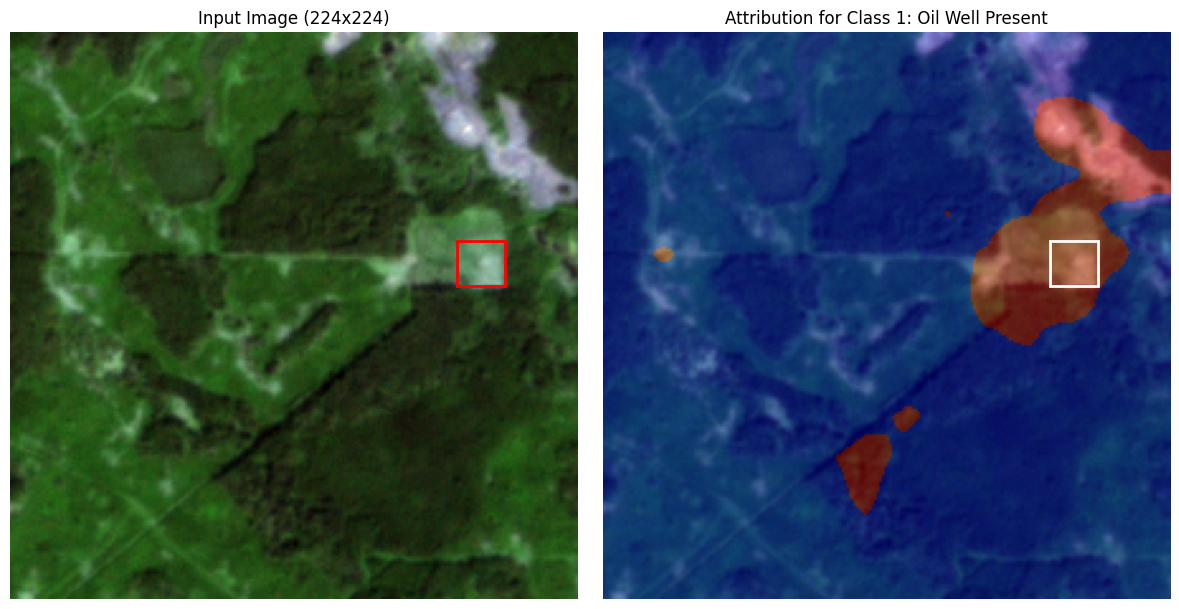


--- Displaying Sample 2 (GT: Oil Well Present) ---
Original Size: 406x406. Scaled Boxes: 1 found.
Top 2 classes:
	0 : No Oil Well     		value = 0.292	 prob = 61.8%
	1 : Oil Well Present		value = -0.188	 prob = 38.2%


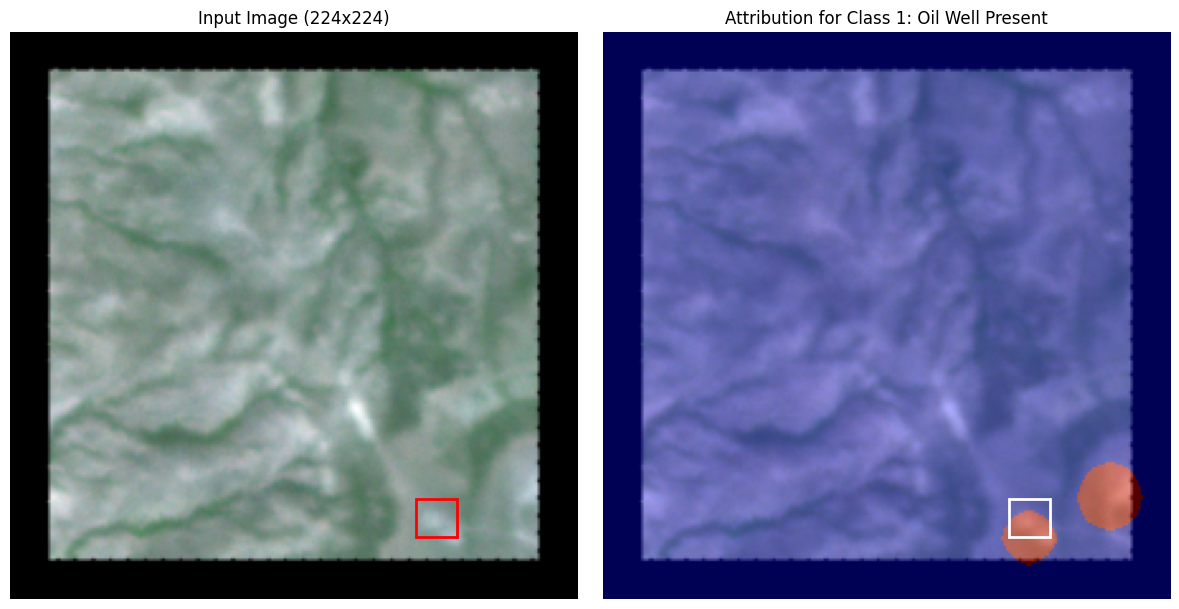


--- Displaying Sample 3 (GT: Oil Well Present) ---
Original Size: 409x409. Scaled Boxes: 11 found.
Top 2 classes:
	1 : Oil Well Present		value = 3.970	 prob = 99.9%
	0 : No Oil Well     		value = -3.227	 prob = 0.1%


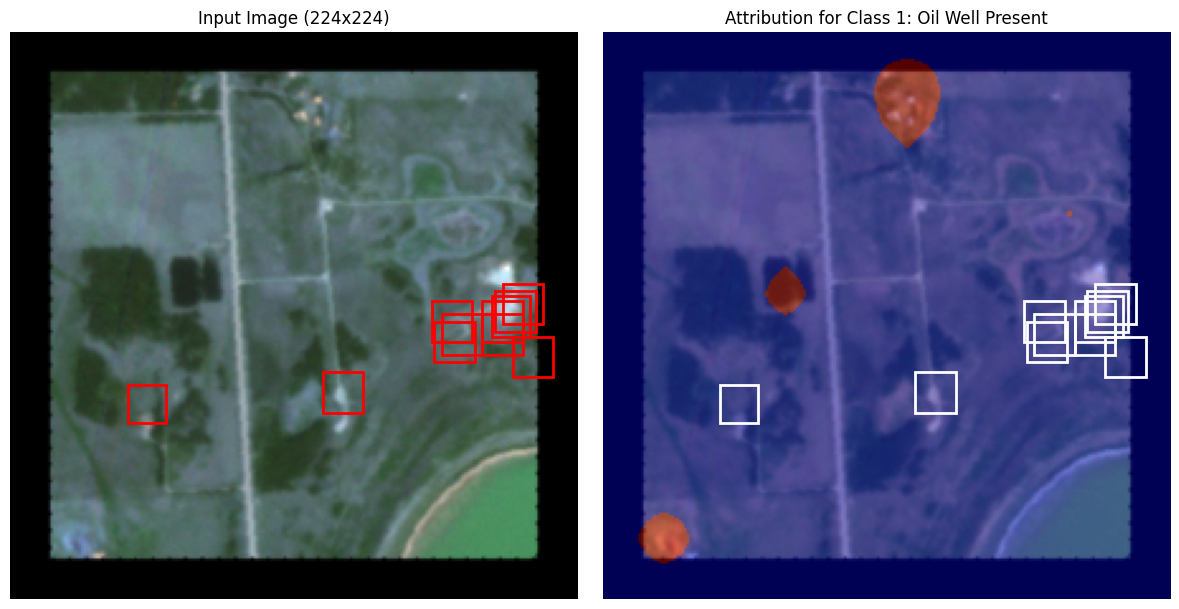


--- Displaying Sample 4 (GT: Oil Well Present) ---
Original Size: 406x406. Scaled Boxes: 1 found.
Top 2 classes:
	1 : Oil Well Present		value = 2.687	 prob = 98.2%
	0 : No Oil Well     		value = -1.325	 prob = 1.8%


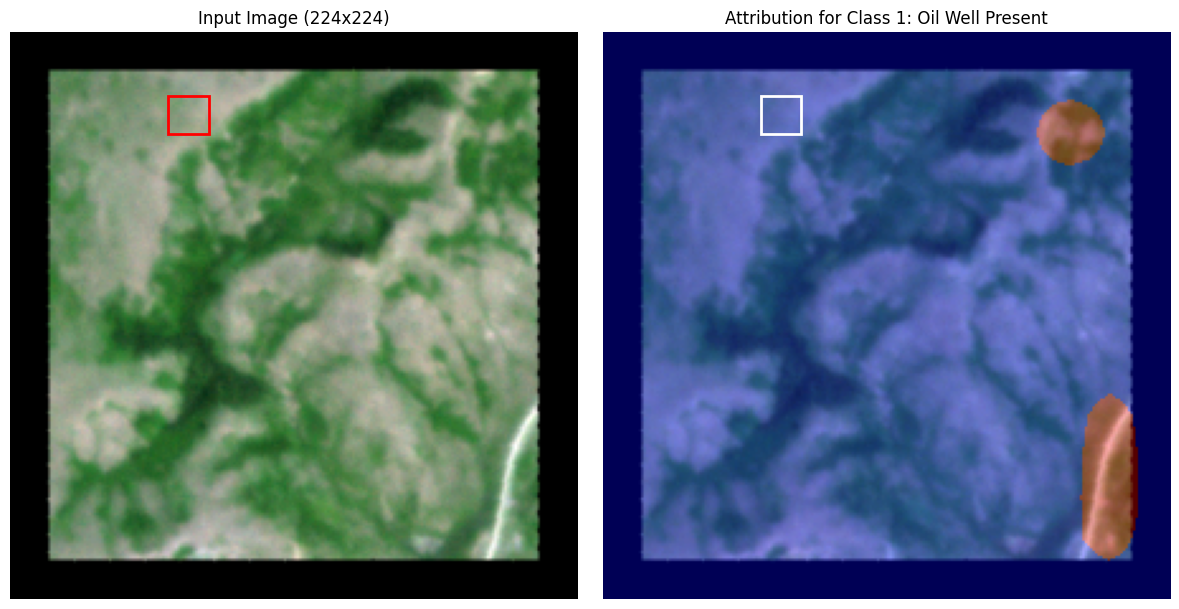


--- Displaying Sample 5 (GT: Oil Well Present) ---
Original Size: 351x351. Scaled Boxes: 1 found.
Top 2 classes:
	1 : Oil Well Present		value = 4.928	 prob = 100.0%
	0 : No Oil Well     		value = -3.576	 prob = 0.0%


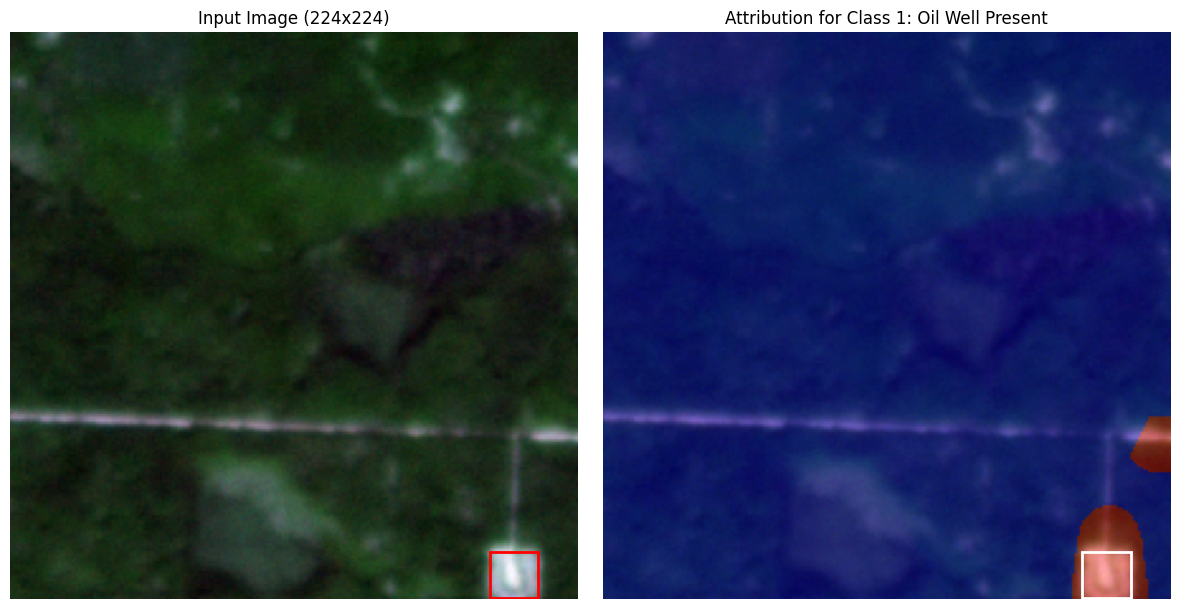


--- Displaying Sample 6 (GT: Oil Well Present) ---
Original Size: 408x408. Scaled Boxes: 1 found.
Top 2 classes:
	1 : Oil Well Present		value = 2.294	 prob = 96.0%
	0 : No Oil Well     		value = -0.893	 prob = 4.0%


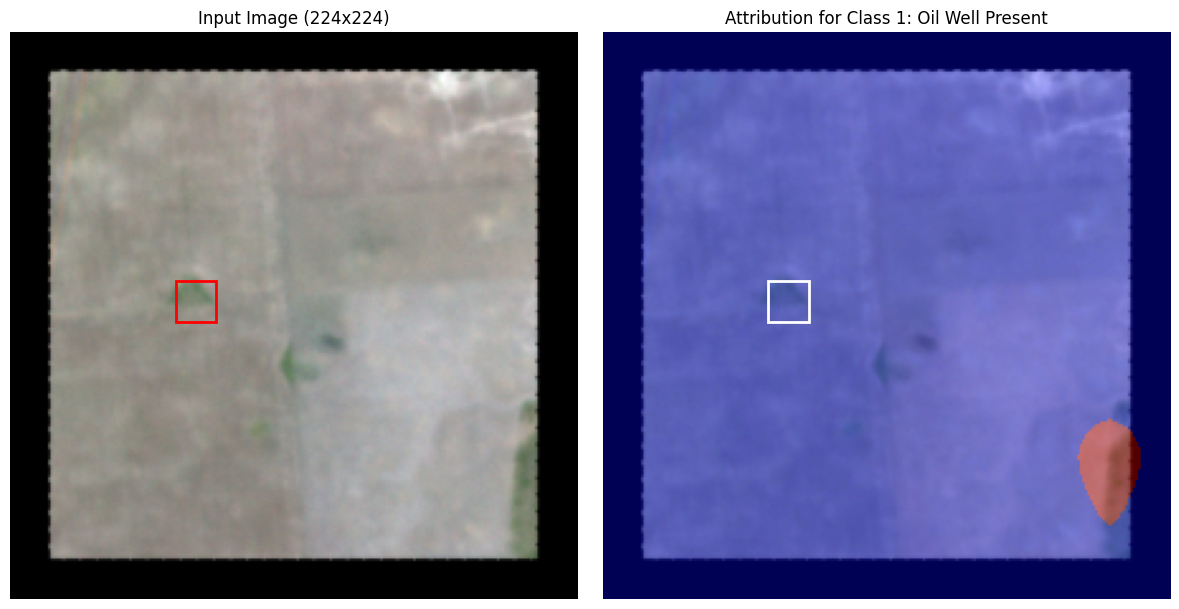


--- Displaying Sample 7 (GT: Oil Well Present) ---
Original Size: 406x406. Scaled Boxes: 1 found.
Top 2 classes:
	1 : Oil Well Present		value = 4.639	 prob = 100.0%
	0 : No Oil Well     		value = -4.212	 prob = 0.0%


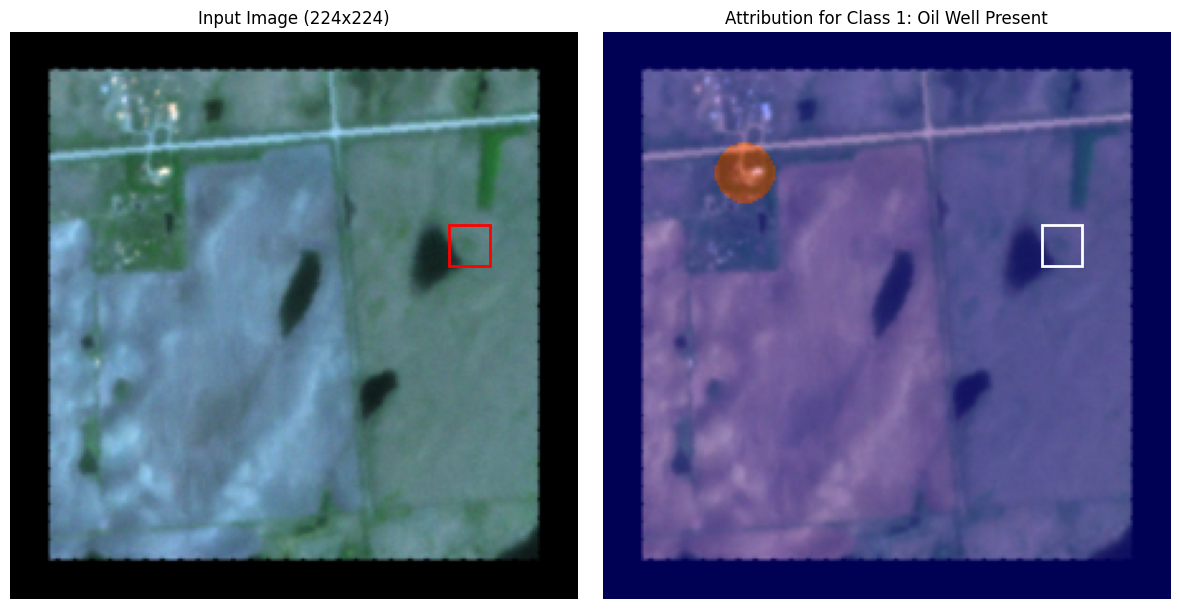


--- Displaying Sample 8 (GT: Oil Well Present) ---
Original Size: 351x351. Scaled Boxes: 2 found.
Top 2 classes:
	1 : Oil Well Present		value = 4.538	 prob = 100.0%
	0 : No Oil Well     		value = -3.122	 prob = 0.0%


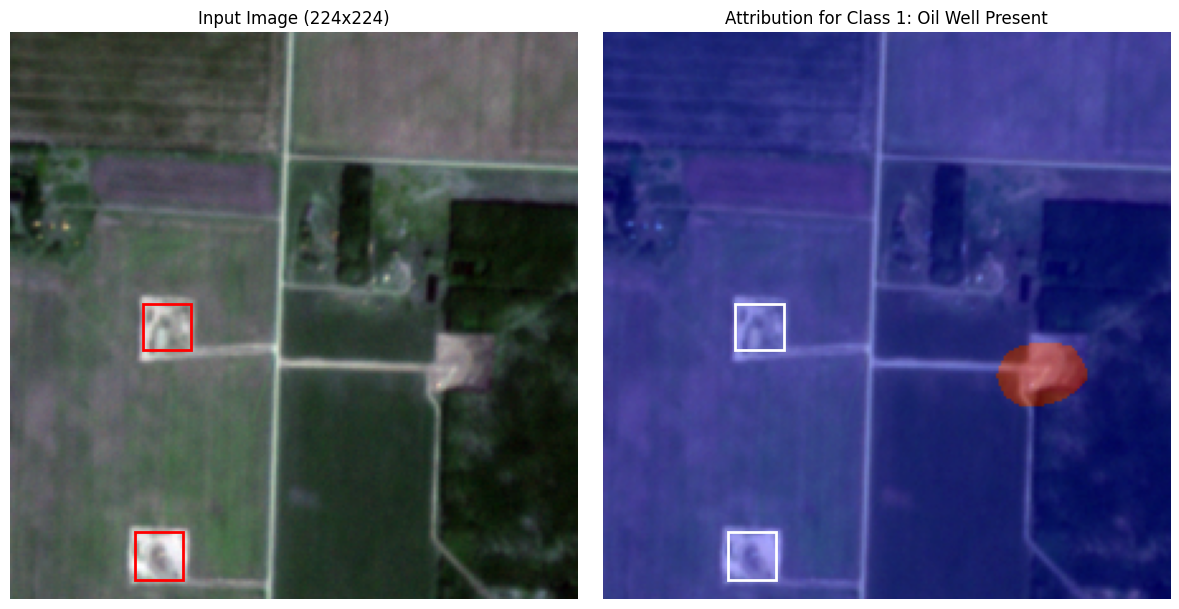


--- Displaying Sample 9 (GT: Oil Well Present) ---
Original Size: 350x351. Scaled Boxes: 3 found.
Top 2 classes:
	1 : Oil Well Present		value = 5.535	 prob = 100.0%
	0 : No Oil Well     		value = -4.934	 prob = 0.0%


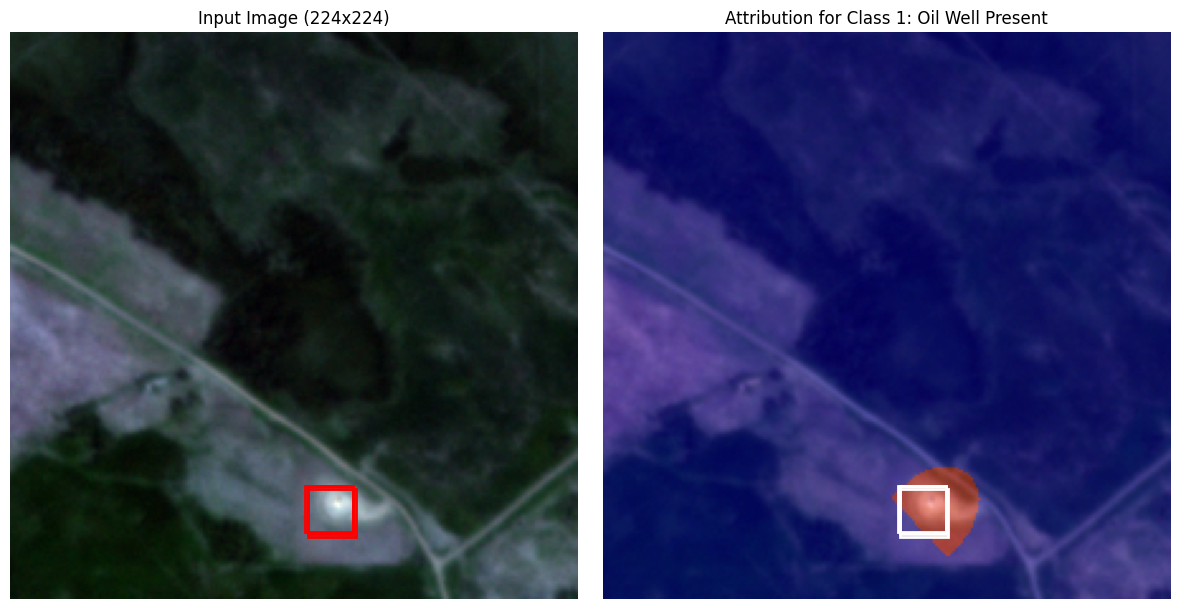


--- Displaying Sample 10 (GT: Oil Well Present) ---
Original Size: 408x408. Scaled Boxes: 1 found.
Top 2 classes:
	1 : Oil Well Present		value = 1.906	 prob = 97.4%
	0 : No Oil Well     		value = -1.700	 prob = 2.6%


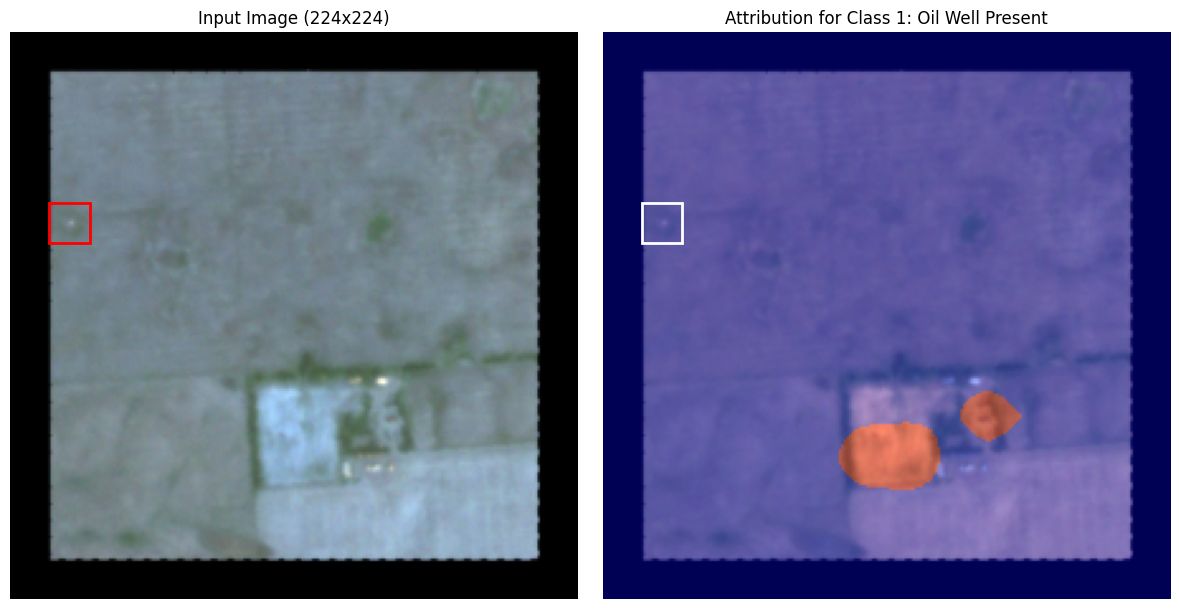

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import random

use_thresholding = True
CLS2IDX = {
    0: 'No Oil Well',
    1: 'Oil Well Present'
}
model.eval()

# ASSUMPTION: The target size of your transform is (224, 224)
TARGET_SIZE = 224

# Function to rescale bounding box coordinates from original image size to target size
def rescale_boxes(boxes, original_size, target_size):
    if isinstance(target_size, int):
        target_h = target_w = target_size
    else:
        target_h, target_w = target_size

    original_h, original_w = original_size

    scale_w = target_w / original_w
    scale_h = target_h / original_h

    rescaled_boxes = boxes.copy()
    rescaled_boxes[:, 0] = boxes[:, 0] * scale_w # x_min
    rescaled_boxes[:, 2] = boxes[:, 2] * scale_w # x_max
    rescaled_boxes[:, 1] = boxes[:, 1] * scale_h # y_min
    rescaled_boxes[:, 3] = boxes[:, 3] * scale_h # y_max

    return rescaled_boxes.astype(int)


# 1. Collect all data items that are Class 1
class1_samples = []

# NOTE: Unpacking 5 variables from the loader: images, labels, boxes, h, w
for i, (images, labels, boxes, original_h_tensor, original_w_tensor) in enumerate(train_loader):
    if labels.item() == 1:
        # Store numpy data and metadata
        image_np = images.cpu().numpy()
        label_item = labels.item()
        boxes_np_list = boxes.cpu().numpy().reshape(-1, 4)

        # Get original dimensions from the loader output (must use .item() to get scalar)
        original_h = original_h_tensor.item()
        original_w = original_w_tensor.item()

        # Store all necessary information for later plotting
        class1_samples.append((image_np, label_item, boxes_np_list, original_h, original_w))

# 2. Shuffle the collected Class 1 samples
random.shuffle(class1_samples)

print(f"Found and shuffled {len(class1_samples)} images of Class 1. Displaying first 10...")

# 3. Iterate and plot the first 10 shuffled samples
count = 0
# NOTE: Unpacking 5 variables from the stored list
for img_np_cpu, label_gt, original_boxes_np, original_h, original_w in class1_samples:
    if count >= 10:
        break

    # >>> Rescale the Bounding Boxes using the stored original size <<<
    rescaled_boxes_np = rescale_boxes(original_boxes_np,
                                      original_size=(original_h, original_w),
                                      target_size=TARGET_SIZE)

    # Convert CPU numpy data back to CUDA tensor for model processing
    image_tensor = torch.from_numpy(img_np_cpu).cuda()
    image_tensor.requires_grad = True

    # --- 1. Model Prediction & Print ---

    output_for_print = model(image_tensor)

    print(f"\n--- Displaying Sample {count+1} (GT: {CLS2IDX[label_gt]}) ---")
    print(f"Original Size: {original_w}x{original_h}. Scaled Boxes: {len(rescaled_boxes_np)} found.")
    print_top_classes(output_for_print.detach())

    # --- 2. Generate Attribution (Class 1 only) ---
    vis_class_1 = generate_visualization(image_tensor.squeeze(0), class_index=1)

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Prepare input image for display (it's already resized to 224x224 by your transform)
    input_img_np_display = img_np_cpu.squeeze(0).transpose(1, 2, 0)
    input_img_np_display = (input_img_np_display - input_img_np_display.min()) / (input_img_np_display.max() - input_img_np_display.min())

    axs[0].imshow(input_img_np_display);
    axs[0].set_title(f"Input Image ({TARGET_SIZE}x{TARGET_SIZE})")
    axs[0].axis('off');

    axs[1].imshow(vis_class_1);
    axs[1].set_title(f"Attribution for Class 1: {CLS2IDX[1]}")
    axs[1].axis('off');

    # >>> Add ALL Rescaled Bounding Boxes to both plots <<<
    for bbox in rescaled_boxes_np:
        x_min, y_min, x_max, y_max = bbox

        # Add to Input Image Plot
        rect0 = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='red', facecolor='none')
        axs[0].add_patch(rect0)

        # Add to Attribution Plot
        rect1 = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='white', facecolor='none')
        axs[1].add_patch(rect1)

    plt.tight_layout()
    plt.show()

    count += 1


Top 5 classes:
	282 : tiger cat       		value = 10.559	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.059	 prob = 15.3%
	285 : Egyptian cat    		value = 8.414	 prob = 8.0%
	243 : bull mastiff    		value = 7.425	 prob = 3.0%
	811 : space heater    		value = 5.152	 prob = 0.3%


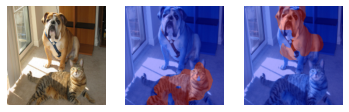

In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
prev_use_thresholding = use_thresholding
if not use_thresholding:
  use_thresholding = True
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

if not prev_use_thresholding:
  use_thresholding = False

axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	101 : tusker                              		value = 11.216	 prob = 37.9%
	340 : zebra                               		value = 10.973	 prob = 29.7%
	386 : African elephant, Loxodonta africana		value = 10.747	 prob = 23.7%
	385 : Indian elephant, Elephas maximus    		value = 9.547	 prob = 7.2%
	343 : warthog                             		value = 5.566	 prob = 0.1%


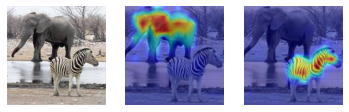

In [ ]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# tusker - the predicted class
tusker = generate_visualization(tusker_zebra_image)

# zebra
# generate visualization for class 340: 'zebra'
zebra = generate_visualization(tusker_zebra_image, class_index=340)


axs[1].imshow(tusker);
axs[1].axis('off');
axs[2].imshow(zebra);
axs[2].axis('off');

Top 5 classes:
	161 : basset, basset hound         		value = 10.514	 prob = 78.8%
	163 : bloodhound, sleuthhound      		value = 8.604	 prob = 11.7%
	166 : Walker hound, Walker foxhound		value = 7.446	 prob = 3.7%
	162 : beagle                       		value = 5.561	 prob = 0.6%
	168 : redbone                      		value = 5.249	 prob = 0.4%


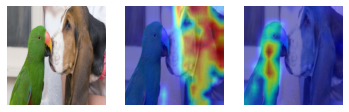

In [ ]:
image = Image.open('samples/dogbird.png')
dog_bird_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 87: 'African grey, African gray, Psittacus erithacus (grey parrot)'
parrot = generate_visualization(dog_bird_image, class_index=87)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');

# **DeiT examples**

In [ ]:
from baselines.ViT.ViT_LRP import deit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

# initialize ViT pretrained with DeiT
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

Top 5 classes:
	243 : bull mastiff    		value = 5.992	 prob = 19.0%
	282 : tiger cat       		value = 5.175	 prob = 8.4%
	285 : Egyptian cat    		value = 4.781	 prob = 5.7%
	281 : tabby, tabby cat		value = 4.690	 prob = 5.2%
	245 : French bulldog  		value = 2.991	 prob = 0.9%


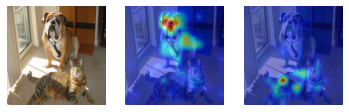

In [ ]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# dog
# generate visualization for class 243: 'bull mastiff' - the predicted class
dog = generate_visualization(dog_cat_image)

# cat - generate visualization for class 282 : 'tiger cat'
cat = generate_visualization(dog_cat_image, class_index=282)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');

Top 5 classes:
	340 : zebra                               		value = 6.759	 prob = 32.7%
	101 : tusker                              		value = 5.557	 prob = 9.8%
	386 : African elephant, Loxodonta africana		value = 5.477	 prob = 9.1%
	385 : Indian elephant, Elephas maximus    		value = 4.774	 prob = 4.5%
	925 : consomme                            		value = 2.237	 prob = 0.4%


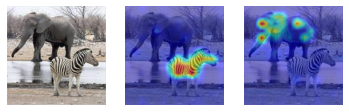

In [ ]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# zebra
# zebra- the predicted class
zebra = generate_visualization(tusker_zebra_image, class_index=340)

# generate visualization for class 101: 'tusker'
tusker = generate_visualization(tusker_zebra_image, class_index=101)

axs[1].imshow(zebra);
axs[1].axis('off');
axs[2].imshow(tusker);
axs[2].axis('off');

Top 5 classes:
	161 : basset, basset hound         		value = 6.327	 prob = 26.5%
	90 : lorikeet                     		value = 4.394	 prob = 3.8%
	88 : macaw                        		value = 4.055	 prob = 2.7%
	166 : Walker hound, Walker foxhound		value = 3.394	 prob = 1.4%
	163 : bloodhound, sleuthhound      		value = 3.352	 prob = 1.4%


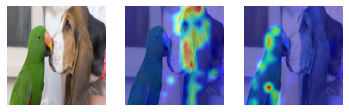

In [ ]:
image = Image.open('samples/dogbird.png')
dog_bird_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 90: 'lorikeet'
parrot = generate_visualization(dog_bird_image, class_index=90)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');